In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils
import circuitsvis as cv
import plotly.express as px
import pandas as pd
from fancy_einsum import einsum

In [2]:
# model parameter constants
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 32
D_HEAD = 32
D_MLP = None
D_VOCAB = 64
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:

def line(tensor, line_labels=None, yaxis="", xaxis="", **kwargs):
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.detach().numpy()
    
    df = pd.DataFrame({
        xaxis: np.arange(len(tensor)),
        yaxis: tensor
    })
    
    fig = px.line(df, x=xaxis, y=yaxis, labels={xaxis: xaxis, yaxis: yaxis}, **kwargs)
    
    if line_labels:
        for c, label in enumerate(line_labels):
            fig.data[c].name = label

    fig.show()

Generating lists of a fixed length parameter

In [4]:
# data generation
import random

FIXED_LENGTH = 10

def generateLists(n, training=True):
    output = []
    for _ in range(n):
        curr = []
        for _ in range(FIXED_LENGTH):
            if training:
                curr.append(random.randint(0, D_VOCAB - 1))
            else:
                curr.append(random.randint(D_VOCAB // 2, D_VOCAB - 1))
            # curr.append(random.randint(0, 100))

        # maximum = max(curr)
        # output.append((curr, maximum))
        output.append(curr)

    output = torch.tensor(output)
    return output

In [5]:
# def generateRandomLists():
#     data = list(itertools.product(range(D_VOCAB), repeat=FIXED_LENGTH))
#     data = torch.tensor(data)
#     return data

# generateRandomLists()

Generating data function with separate training and testing data so it doesn't see what
it's being tested on. Data generator

In [6]:
def separate_data(n, split=0.7):
    output = []
    for i in range(D_VOCAB):
        for j in range(D_VOCAB):
            curr = [i, j]
            output.append(curr)

    random.shuffle(output)

    split_index = int(len(output) * split)
    # return training, testing
    return torch.tensor(output[:split_index]), torch.tensor(output[split_index:])

In [7]:
def output_data(data, batch_size=128):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

Attempt at cross-validation

In [8]:
def raw_generate():
    output = []
    for i in range(D_VOCAB):
        for j in range(D_VOCAB):
            curr = [i, j]
            output.append(curr)

    random.shuffle(output)
    return output

def cross_val_generate(output, epoch, total_epoch):
    testing_size = int(len(output) / total_epoch)
    split_index = testing_size * epoch
    # return training, testing
    testing = torch.tensor(output[split_index:split_index + testing_size])
    training = torch.tensor(output[:split_index] + output[split_index + testing_size:])
    return training, testing

Generating variable length lists without separation

In [43]:
def generateVariableLists(n, seen, training=True):
    output = []
    index = 0

    while index < n:
        i = 0
        j = random.randint(0, FIXED_LENGTH)
        curr = []
        while i < j:
            curr.append(random.randint(0, D_VOCAB - 1))
            i += 1
        while i < FIXED_LENGTH:
            curr.append(0)
            i += 1

        if training:
            seen.add(tuple(curr))
            output.append(curr)
            index += 1
        else:
            if tuple(curr) not in seen:
                output.append(curr)
                index += 1
    
    output = torch.tensor(output)
    return output

generateVariableLists(10, set())

tensor([[ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 5, 25,  0,  0,  0,  0,  0,  0,  0,  0],
        [45, 52, 50, 32, 48, 19, 63, 46, 29, 57],
        [13, 29, 45, 48, 58,  0,  0,  0,  0,  0],
        [21, 15, 26, 51, 56, 55, 51,  0,  0,  0],
        [42, 48, 35, 48, 26,  0,  0,  0,  0,  0],
        [53,  3,  7,  2, 46, 56, 56, 48,  0,  0],
        [63, 15, 25, 41, 25,  1,  9, 44,  0,  0],
        [ 4, 28, 52, 59, 30, 31, 39, 17, 37, 41],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

Model paramters. We are using one layer, one attention head (which pays to the 
tokens in contex to another), the dimensions of the model, dimension of the head,
vocab is the size of the logits

In [10]:
# model setup
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=FIXED_LENGTH,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True
)

# hooked transformer used for interpretation later
model = HookedTransformer(cfg, move_to_device=True)

In [11]:
def loss_function(logits, tokens, return_per_token=True, print_tokens=False):
    # we take the last element of the logits to make the next prediction
    logits = logits[:, -1, :]
    answer = torch.max(tokens, dim=1)[0]
    log_prob = logits.log_softmax(-1)
    if print_tokens:
        print("tokens", tokens)
        print("predicted", torch.argmax(logits, dim=-1))
    # shape is (batch_size, 1) which represents probabilities 
    # of the correct answer
    output_prob = log_prob.gather(-1, answer.unsqueeze(-1))
    if return_per_token:
        return -1 * output_prob.squeeze()
    return -1 * output_prob.mean()

In [12]:
def accuracy(logits, tokens, return_per_token=False):
    logits = logits[:, -1, :]
    predicted = torch.argmax(logits, dim=1)
    answer = torch.max(tokens, dim=1)[0]
    if return_per_token:
        return (predicted == answer).float()
    return (predicted == answer).float().mean().item()

In [13]:
x = torch.tensor([[1], [2], [3], [4]])

In [14]:
def train_model(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

    seen = set()
    train_losses = []
    for epoch in range(n_epochs):
        epoch_losses = []
        for _ in range(batches_per):
            tokens = generateVariableLists(batch_size, seen, training=True)
            logits = model(tokens)
            # print(tokens.shape)
            # print(logits.shape)
            losses = loss_function(logits, tokens, print_tokens=False)
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_losses.extend(losses.detach())

        train_losses.append(np.mean(epoch_losses))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")

    model.eval()
    # might want to create the training and testing set beforehand
    test_data = generateVariableLists(1280, seen, training=False)
    logits = model(test_data)
    acc = accuracy(logits, test_data, return_per_token=False)

    print(f"Test accuracy: {acc}")

    return train_losses, seen
                

Separate training and testing

In [15]:
def train_model2(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

    train_losses = []
    training_data, testing_data = separate_data(batch_size)

    for epoch in range(n_epochs):
        data_generator = output_data(training_data, batch_size)
        epoch_losses = []
        for _ in range(batches_per):
            tokens = next(data_generator)
            logits = model(tokens)
            # print(tokens.shape)
            # print(logits.shape)
            losses = loss_function(logits, tokens, print_tokens=False)
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_losses.extend(losses.detach())

        train_losses.append(np.mean(epoch_losses))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")

    model.eval()
    # might want to create the training and testing set beforehand
    logits = model(testing_data)
    acc = accuracy(logits, testing_data, return_per_token=False)

    print(f"Test accuracy: {acc}")

    return train_losses
                

Cross validation

In [16]:
def cross_val(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

    train_losses = []
    all_data = raw_generate()

    for epoch in range(n_epochs):
        tokens, test = cross_val_generate(all_data, epoch, n_epochs - 1)
        epoch_losses = []
        for _ in range(batches_per):
            logits = model(tokens)
            # print(tokens.shape)
            # print(logits.shape)
            losses = loss_function(logits, tokens, print_tokens=False)
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_losses.extend(losses.detach())

        train_losses.append(np.mean(epoch_losses))

        model.eval()
        logits = model(test)
        acc = accuracy(logits, test, return_per_token=False)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")
            print(f"Test accuracy: {acc}")

    return train_losses
                

In [63]:
losses, seen = train_model(model, 100, 128, 10, 3)

Epoch 0, train loss: 0.047225527465343475
Epoch 10, train loss: 0.025252658873796463
Epoch 20, train loss: 0.0349581353366375
Epoch 30, train loss: 0.017877962440252304
Epoch 40, train loss: 0.012119730934500694
Epoch 50, train loss: 0.012458376586437225
Epoch 60, train loss: 0.013950640335679054
Epoch 70, train loss: 0.009471715427935123
Epoch 80, train loss: 0.017646411433815956
Epoch 90, train loss: 0.0024585756473243237
Test accuracy: 1.0


In [64]:
line(losses, xaxis="Epoch", yaxis="Loss")

Visualizing Attention

In [88]:
# training_data, testing_data = separate_data(128)
# train_data_gen = output_data(training_data)
# tokens = next(train_data_gen)
# logits, cache = model.run_with_cache(tokens)

tokens = generateVariableLists(128, seen, training=False)
special_token = [15, 10, 9, 8, 7, 6, 5, 4, 3, 2]
tokens = torch.cat([torch.tensor([special_token]), tokens], dim=0)

logits, cache = model.run_with_cache(tokens)

In [89]:
attention_pattern = cache["pattern", 0, "attn"]

# print the first answer predicted by logits
print(torch.argmax(logits[:, -1, :], dim=-1))

tensor([ 8, 59, 52, 63, 61, 59, 63, 55, 48, 62, 47, 44, 55, 58, 51, 48, 58, 43,
        60, 46, 62, 61, 58, 57, 56, 24, 57, 51, 60, 58, 60, 60, 35, 55, 49, 60,
        56, 48, 25, 61, 43, 63, 59, 59, 58, 61, 21, 52, 53, 49, 57, 60, 61, 62,
        61, 34, 57, 53, 55, 52, 52, 33, 54, 57, 51, 59, 63, 36, 58, 55,  7, 57,
        61, 60, 38, 53, 55, 59, 60, 48, 33, 48, 60, 49, 21, 54, 54, 63, 51, 59,
        50, 55, 47, 58, 47, 49, 55, 60, 63, 63, 46, 59, 50, 54, 62, 55, 54, 61,
        45, 41, 41, 39, 37, 54, 58, 29, 49, 54, 58, 62, 33, 59, 42, 46, 49, 61,
        37, 61, 63])


In [67]:
cv.attention.attention_heads(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [80]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [23]:
cv.attention.attention_heads(tokens=list(map(lambda t: str(t.item()), tokens[1])), attention=attention_pattern[1])

In [69]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[1])), attention=attention_pattern[1])

Given [x, y] when x is greater than y, then attention pattern of the second one looks at the first one. If y is greater than x, then the second
attention pattern looks at the second one. The second position's attention is always focused on the one with the higher token value which makes
sense. 

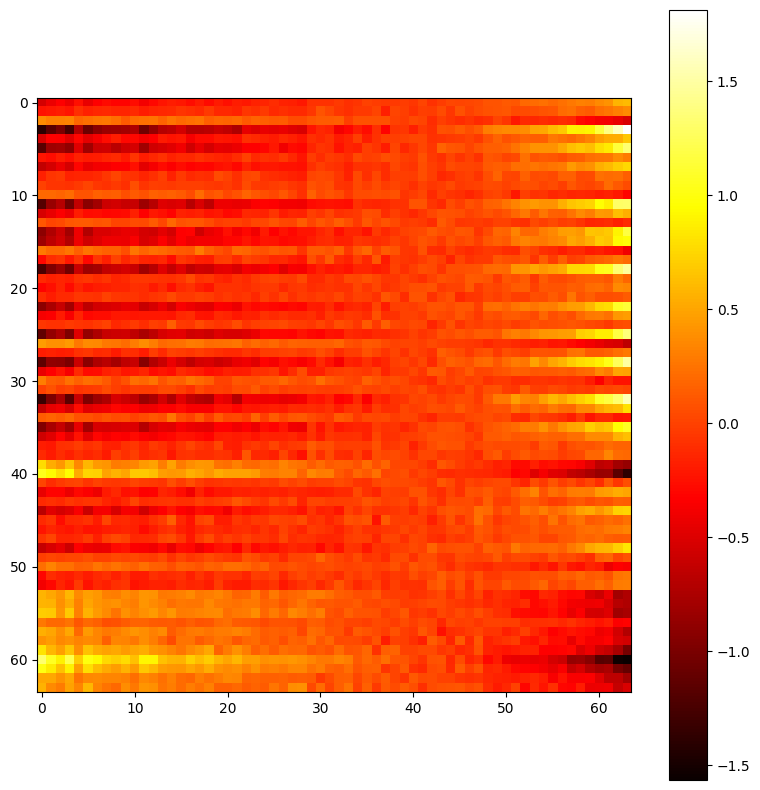

In [25]:
attn = model.blocks[0].attn
all_token_embeddings = model.embed(range(D_VOCAB))

embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                        all_token_embeddings, attn.W_K) 
embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          all_token_embeddings, attn.W_Q) 
                          
plt.rcParams['figure.figsize'] = [20, 10]
qk_circuit_attn_heatmap = einsum(
    "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
    embeddings_query, embeddings_key
    ).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()